Tutorials of CPS using HBC dataset
===
**Interpretations of attention scores**
1. read the dataset
2. construct the graph (construct the multi-scale features, option)
2. train the model
3. generate the arbitrary resolution spots
4. visualize the results

In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import CPS

In [3]:
opt = CPS.config()
args = opt.parse_args(['--seed', '2025'])
args.prep_scale = False
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/4-Human_Breast_Cancer'
args.radius=300
args.max_neighbors = 6
args.clusters=20
args.hvgs=2000
args.sigma=1
args.freq=32
CPS.set_random_seed(args.seed)
args.k_list = [0,1,2,3,4,5,6,7]
# [0,1,2,3,4,5,6,7][0,1,2,3,5,8,13,21][0,1,2,4,6,8,10,12][0,1,2,4,8,16,32,64]
args

Namespace(batch_size=256, clusters=20, coord_dim=2, dataset_path='/mnt/d/Dataset/SRT_Dataset/4-Human_Breast_Cancer', decoder_latent=[256, 512, 1024], distill=1.0, dropout=0.2, embedd_dim=512, er_w=0.05, flow='source_to_target', freq=32, gpu=0, hvgs=2000, inr_latent=[256, 256, 256], k_list=[0, 1, 2, 3, 4, 5, 6, 7], latent_dim=64, lr=0.001, max_epoch=1000, max_neighbors=6, n_spot=0, num_heads=4, prep_scale=False, radius=300, seed=2025, self_loops=True, sigma=1, weight_decay=0.0001)

Read the adata

In [4]:
adata = sc.read_visium(path=args.dataset_path, count_file='filtered_feature_bc_matrix.h5')
Ann_df = pd.read_csv(os.path.join(args.dataset_path, 'metadata.tsv'), sep='\t', header=0, index_col=0)
adata.obs['Ground Truth'] = Ann_df.loc[adata.obs_names, 'ground_truth']
adata

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'Ground Truth'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

Preprocess adata

In [5]:
adata.var_names_make_unique()
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs)
adata_hvg = adata[:, adata.var['highly_variable']].copy()
sc.pp.normalize_total(adata_hvg, target_sum=1e4)
sc.pp.log1p(adata_hvg)
sc.pp.scale(adata_hvg, zero_center=True, max_value=10)

counts_layer = adata_hvg.layers['counts']
adata_hvg.obsm['hvg_features'] = adata_hvg.X
adata_hvg.obsm['hvg_counts'] = counts_layer.toarray()

Construct the spatial graph

In [6]:
spatial_edge = CPS.SpatialGraphBuilder(args)
pyg_data = spatial_edge.build_single_graph(adata_hvg, method='rknn')
print(pyg_data.num_nodes, pyg_data.num_genes, pyg_data.edge_index.shape)

3798 2000 torch.Size([2, 25862])


Train the CPS model

In [7]:
cps_model = CPS.CPSTrainer(args)
cps_model.fit(pyg_data)

  0%|          | 0/1000 [00:00<?, ?it/s]

0.05197848007082939 2.0792903900146484

Epoch   0: Train[Total:6.2965, T:2.9336, S:2.5970, D:0.7659]
0.051978420466184616 2.079289197921753
0.051977600902318954 2.079272747039795
0.051975905895233154 2.0792388916015625
0.05197397619485855 2.079200267791748
0.05197162553668022 2.079153299331665
0.05197026953101158 2.0791261196136475
0.05196770653128624 2.0790748596191406
0.051966678351163864 2.079054355621338
0.05196437984704971 2.0790083408355713
0.051962949335575104 2.078979730606079

Epoch  10: Train[Total:2.7881, T:1.2198, S:1.1708, D:0.3975]
0.05196264013648033 2.0789735317230225
0.05196113511919975 2.0789434909820557
0.05195826292037964 2.078886032104492
0.05195577070116997 2.07883620262146
0.05195465311408043 2.0788137912750244
0.051953017711639404 2.0787811279296875
0.05194888263940811 2.0786983966827393
0.05194420740008354 2.0786049365997314
0.05193963274359703 2.0785133838653564
0.05193450674414635 2.0784108638763428

Epoch  20: Train[Total:2.6183, T:1.1545, S:1.1166, D:0.3472

Downstream analysis

0.0 0.8107761144638062


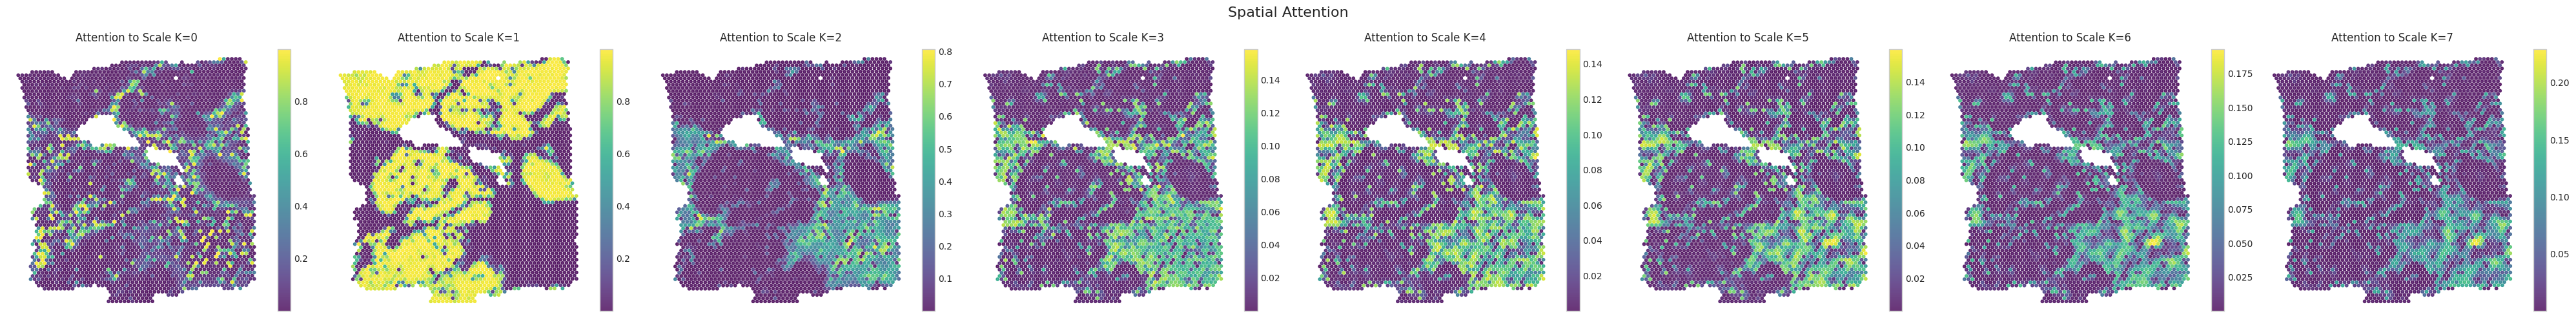

In [8]:
z_s, latent, attn = cps_model.interpret_attn_scores(pyg_data, verbose=True)
adata_hvg.obsm['z_s'] = z_s
adata_hvg.obsm['z_t'] = latent
adata_hvg.obsm['attns'] = attn
adata_hvg.obsm['attn'] = attn.reshape(adata_hvg.n_obs, 32)

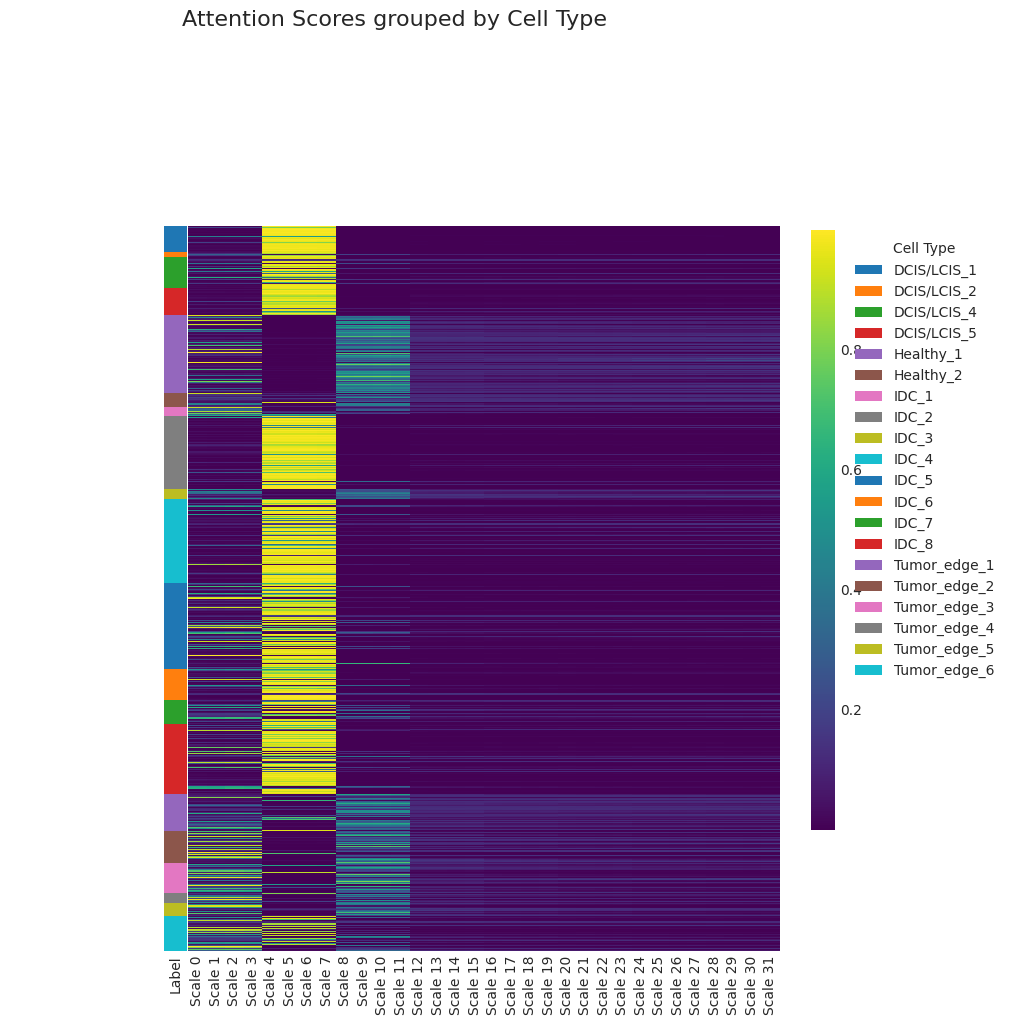

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

df_plot = pd.DataFrame(
    adata_hvg.obsm['attn'], 
    columns=[f'Scale {k}' for k in range(adata_hvg.obsm['attn'].shape[1])]
)
df_plot['Label'] = adata_hvg.obs['Ground Truth'].values
df_sorted = df_plot.sort_values('Label')

data_heatmap = df_sorted.drop(columns=['Label'])
labels = df_sorted['Label']
lut = dict(zip(labels.unique(), sns.color_palette("tab10", len(labels.unique()))))
row_colors = labels.astype(object).map(lut)

g = sns.clustermap(
    data_heatmap,
    row_colors=row_colors,  # 左侧显示类别颜色
    row_cluster=False,      # 关闭行聚类（因为我们要保持按标签排序的顺序）
    col_cluster=False,      # 关闭列聚类（保持 Scale 从小到大的顺序）
    cmap='viridis',         # 颜色
    yticklabels=False,      # 隐藏具体的细胞名（太密了看不清）
    xticklabels=True,       # 显示 Scale 标签
    figsize=(8, 10),        # 调整大小
    cbar_pos=(1.02, 0.2, 0.03, 0.6) # 调整颜色条位置
)

g.fig.suptitle('Attention Scores grouped by Cell Type', y=1.02, fontsize=16)
from matplotlib.patches import Patch
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Cell Type', bbox_to_anchor=(1.3, 1), loc='upper left')

plt.show()

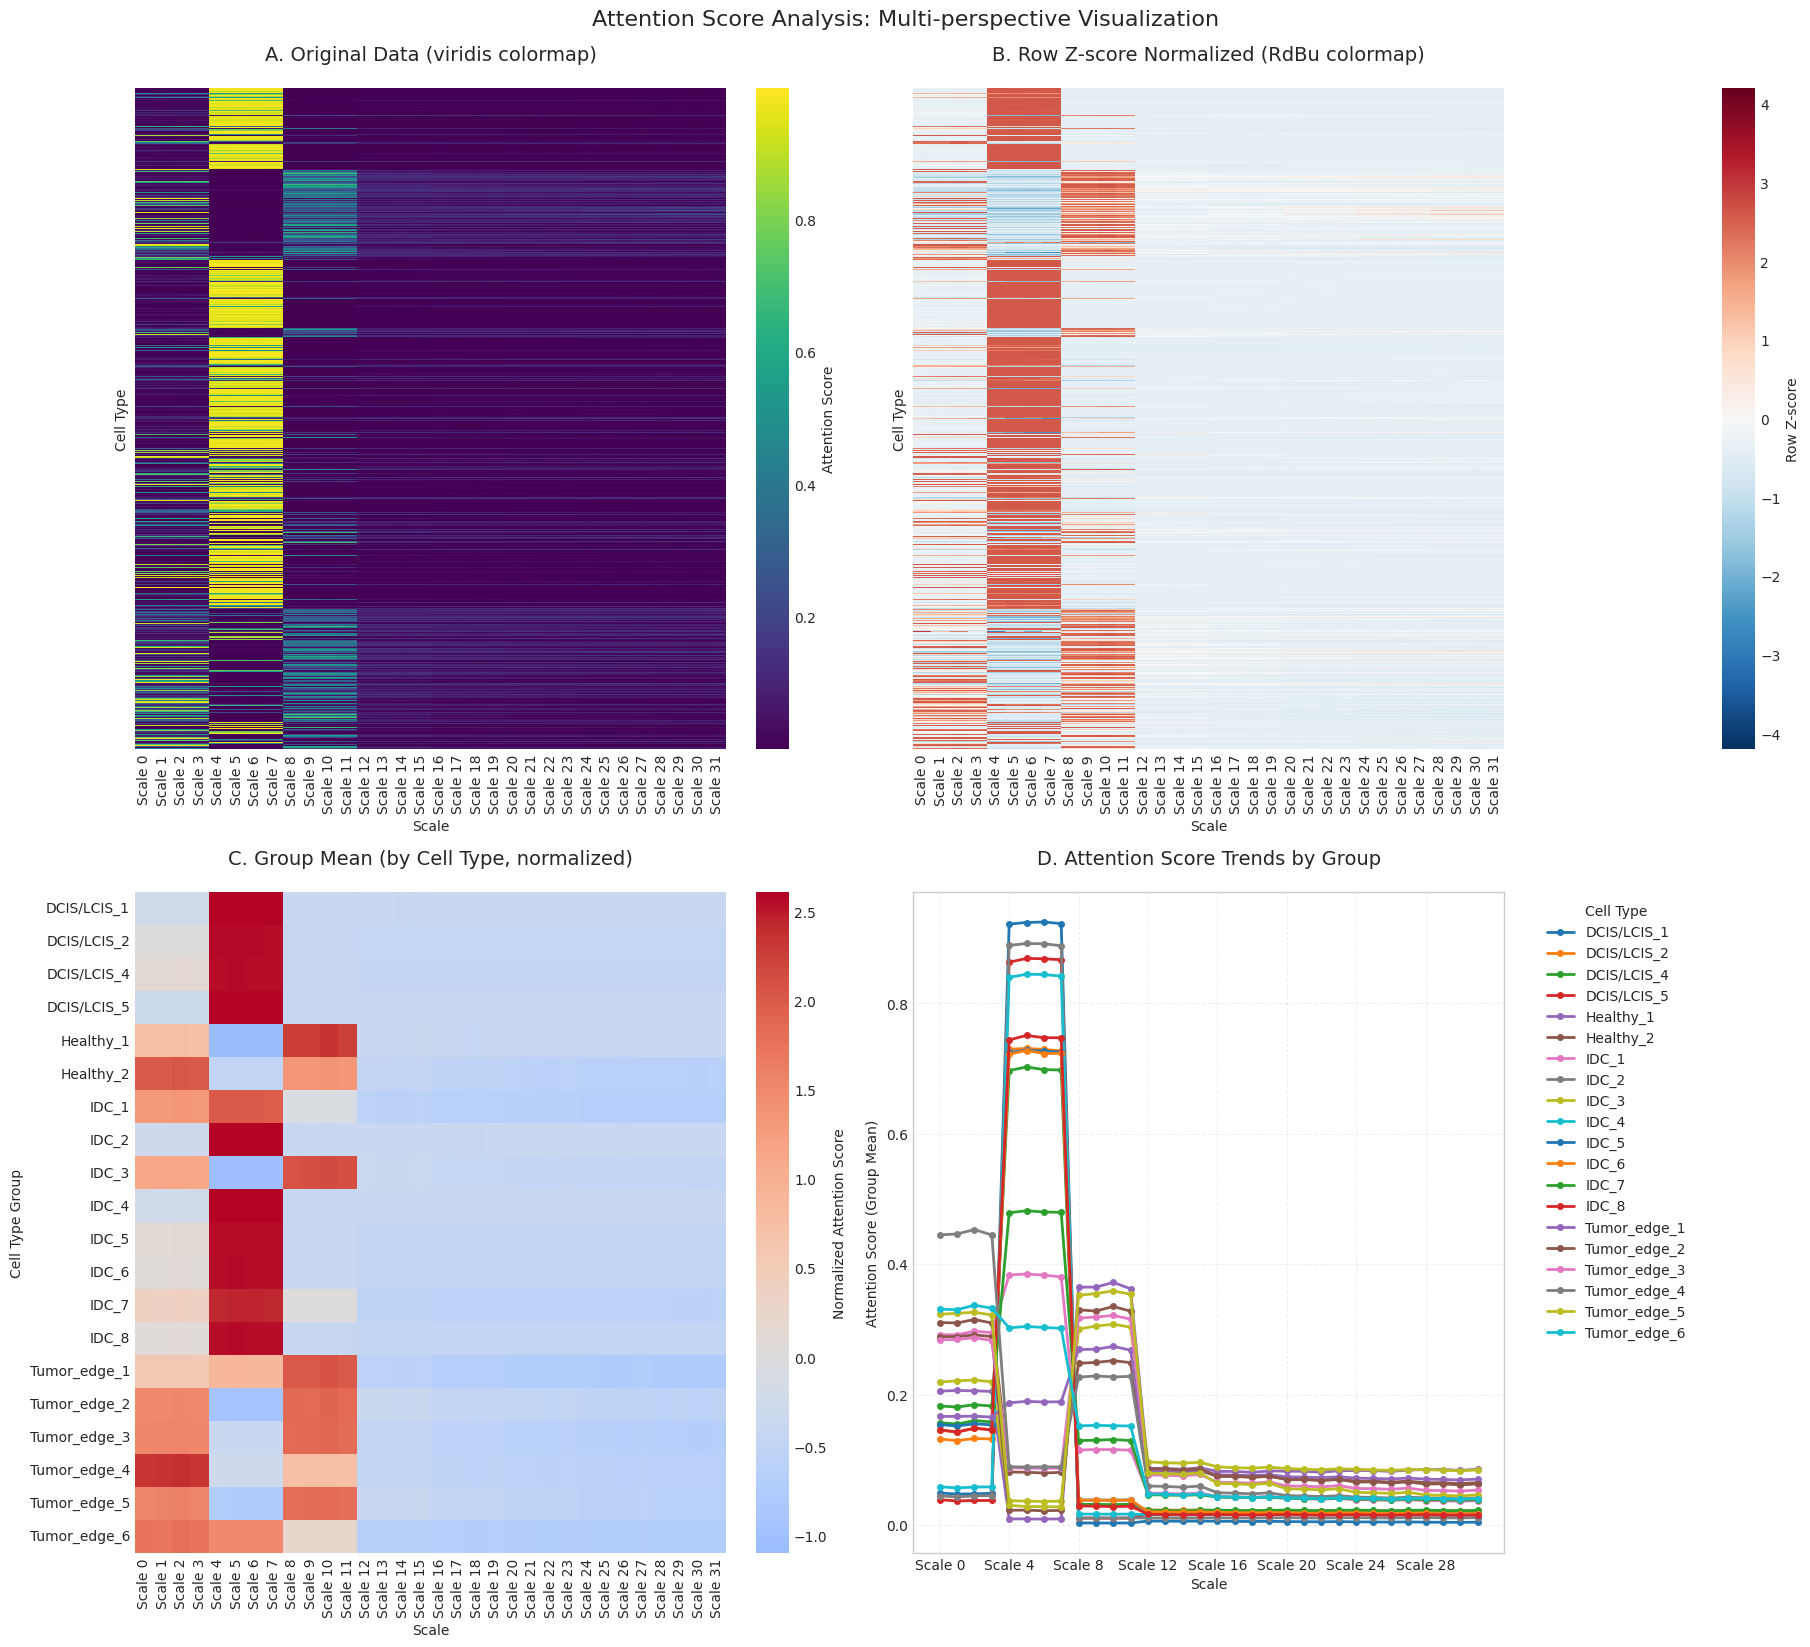

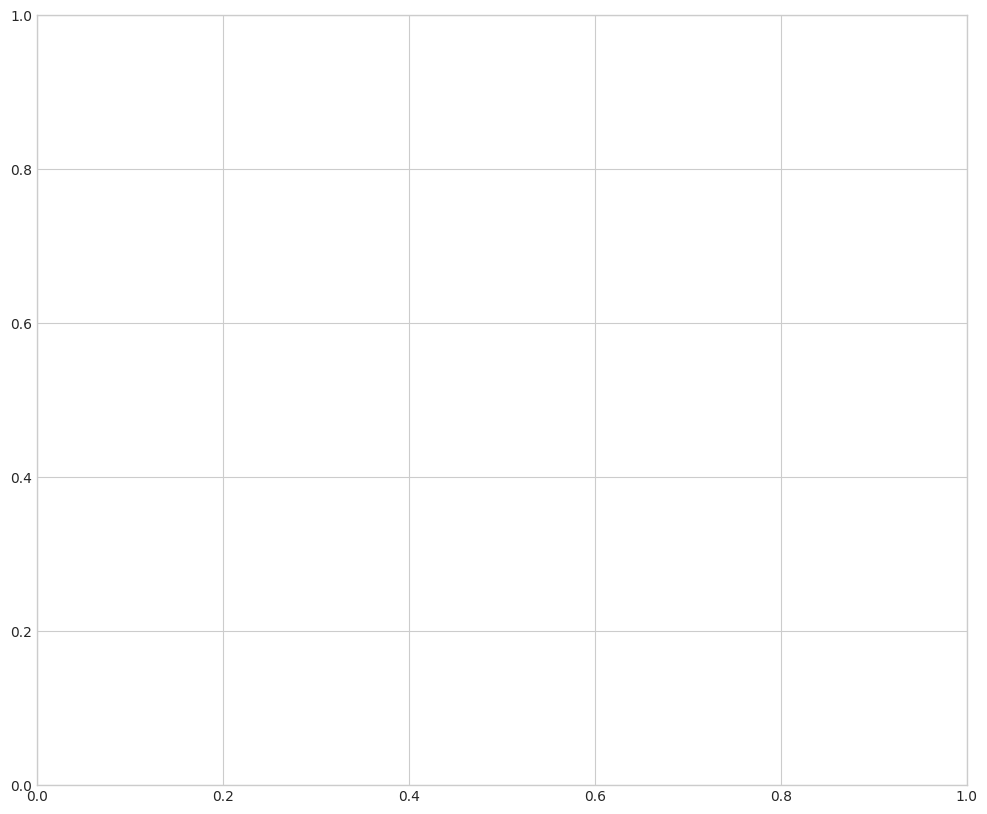

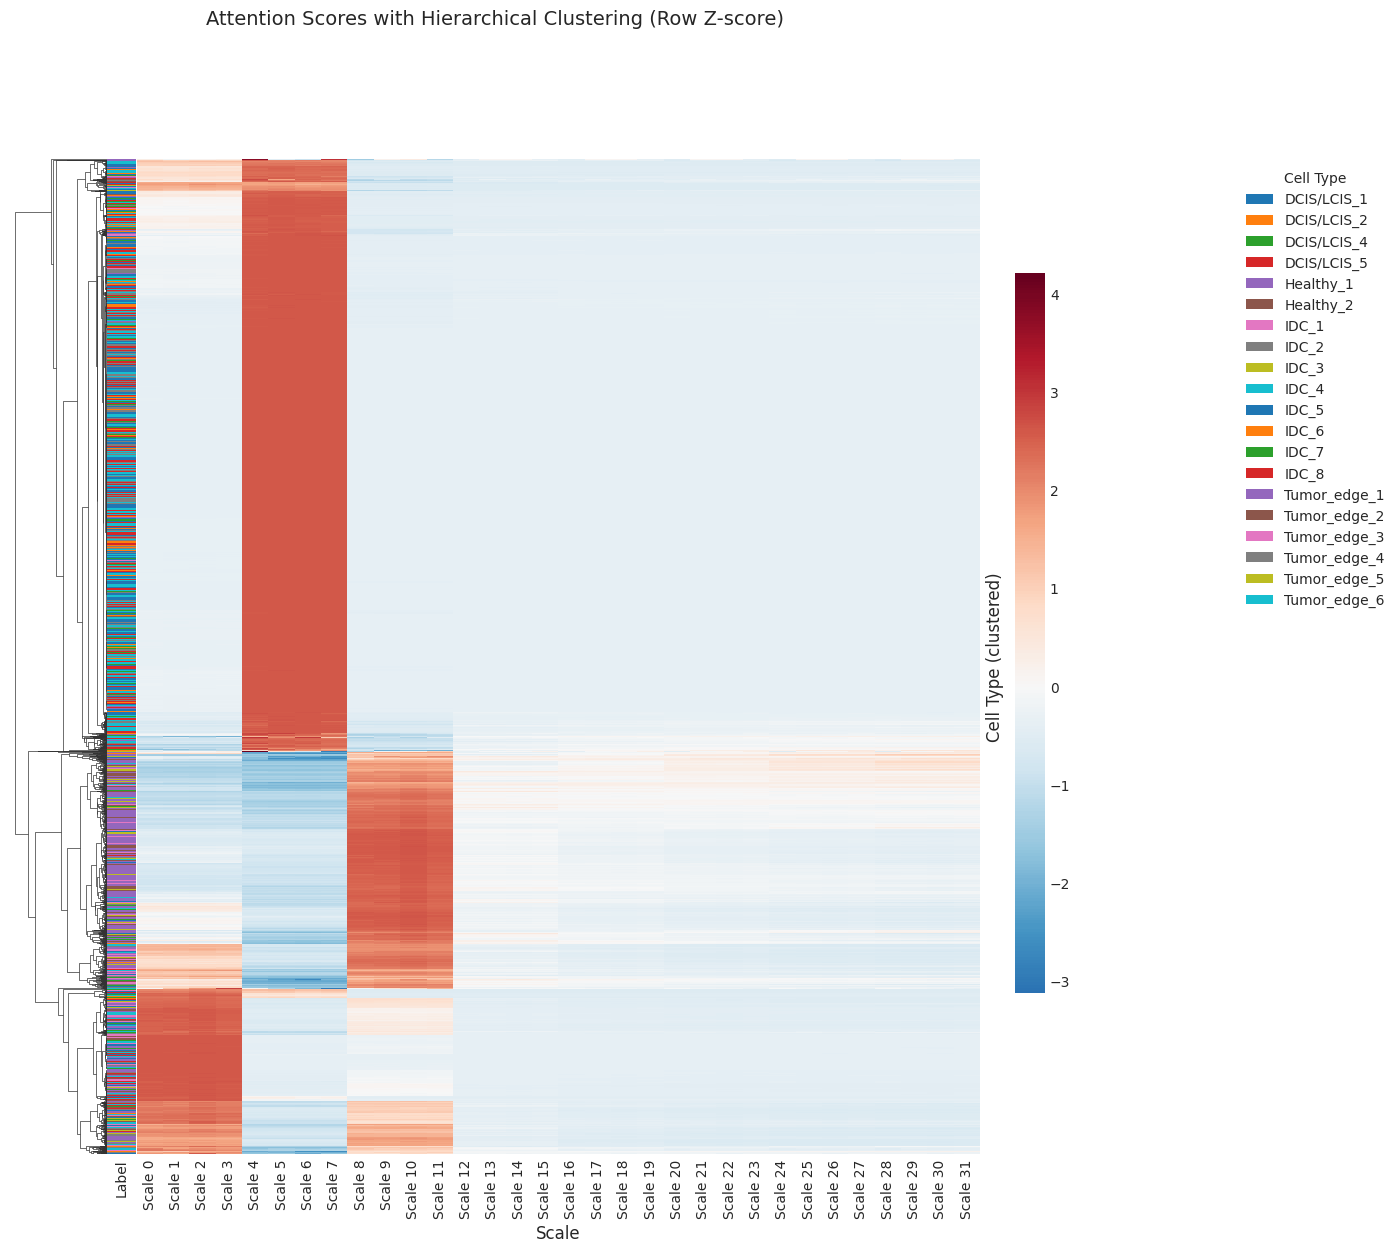

Top 10 scales with highest variance (most informative):
Scale 6     0.200040
Scale 5     0.199957
Scale 7     0.199012
Scale 4     0.197822
Scale 2     0.067136
Scale 1     0.065229
Scale 3     0.064915
Scale 0     0.064739
Scale 10    0.035934
Scale 9     0.034738
dtype: float32


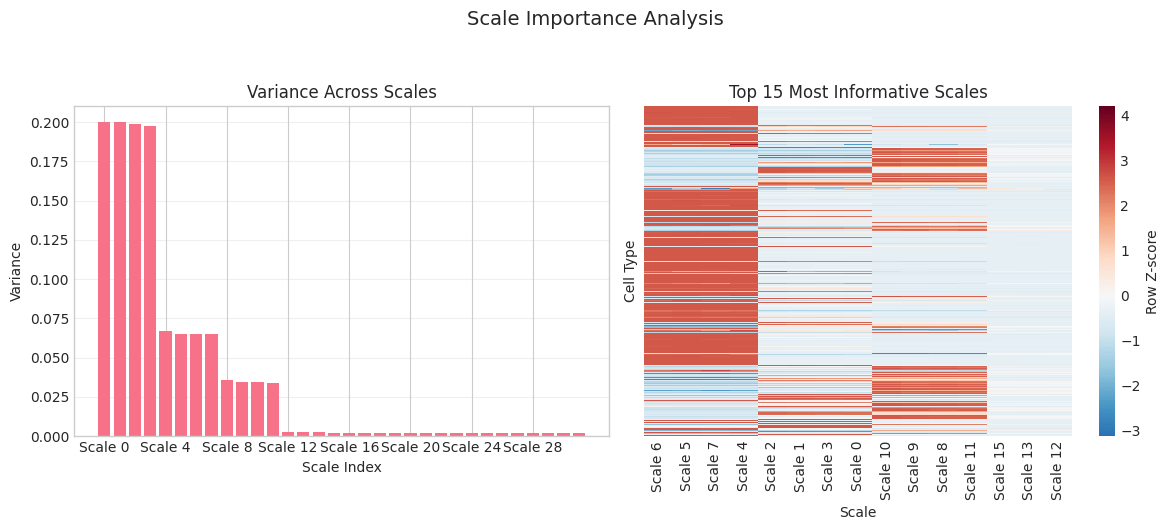

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 准备数据
df_plot = pd.DataFrame(
    adata_hvg.obsm['attn'], 
    columns=[f'Scale {k}' for k in range(adata_hvg.obsm['attn'].shape[1])]
)
df_plot['Label'] = adata_hvg.obs['Ground Truth'].values
df_sorted = df_plot.sort_values('Label')

data_heatmap = df_sorted.drop(columns=['Label'])
labels = df_sorted['Label']

# 1. 对数据进行标准化处理（解决中间值被掩盖的问题）
# 方法1: 行标准化（每个细胞类型的注意力模式）
data_row_normalized = data_heatmap.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

# 方法2: 列标准化（每个尺度的全局比较）
# data_col_normalized = data_heatmap.apply(lambda x: (x - x.mean()) / x.std(), axis=0)

# 方法3: 非线性变换（压缩高值范围）
# data_log = np.log1p(data_heatmap)  # log(1+x)变换
# data_sqrt = np.sqrt(data_heatmap)  # 平方根变换

# 方法4: 截断极端值（设置合理的范围）
# vmax = np.percentile(data_heatmap.values, 95)  # 用95%分位数作为上限
# vmin = np.percentile(data_heatmap.values, 5)   # 用5%分位数作为下限

# 2. 创建颜色映射
lut = dict(zip(labels.unique(), sns.color_palette("tab10", len(labels.unique()))))
row_colors = labels.astype(object).map(lut)

# 3. 创建多个子图对比展示
fig, axes = plt.subplots(2, 2, figsize=(18, 16), constrained_layout=True)

# 子图1: 原始数据，使用感知均匀的色系
vmin1, vmax1 = data_heatmap.values.min(), data_heatmap.values.max()
sns.heatmap(data_heatmap, 
           cmap='viridis', 
           yticklabels=False,
           xticklabels=True,
           ax=axes[0, 0],
           cbar_kws={'label': 'Attention Score'},
           vmin=vmin1, vmax=vmax1)
axes[0, 0].set_title('A. Original Data (viridis colormap)', fontsize=14, pad=20)
axes[0, 0].set_ylabel('Cell Type')
axes[0, 0].set_xlabel('Scale')

# 子图2: 行标准化后的数据（发散色系，突出相对模式）
max_abs = np.max(np.abs(data_row_normalized.values))
sns.heatmap(data_row_normalized, 
           cmap='RdBu_r',  # 红蓝发散色系
           center=0,  # 以0为中心
           yticklabels=False,
           xticklabels=True,
           ax=axes[0, 1],
           cbar_kws={'label': 'Row Z-score'},
           vmin=-max_abs, vmax=max_abs)
axes[0, 1].set_title('B. Row Z-score Normalized (RdBu colormap)', fontsize=14, pad=20)
axes[0, 1].set_ylabel('Cell Type')
axes[0, 1].set_xlabel('Scale')

# 子图3: 按组平均的热图（减少噪声，突出组间差异）
# 计算每个组的平均值
group_means = df_plot.groupby('Label').mean()
# 对行也进行标准化以便比较
group_means_normalized = group_means.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

sns.heatmap(group_means_normalized, 
           cmap='coolwarm',
           center=0,
           yticklabels=True,
           xticklabels=True,
           ax=axes[1, 0],
           cbar_kws={'label': 'Normalized Attention Score'})
axes[1, 0].set_title('C. Group Mean (by Cell Type, normalized)', fontsize=14, pad=20)
axes[1, 0].set_ylabel('Cell Type Group')
axes[1, 0].set_xlabel('Scale')
axes[1, 0].tick_params(axis='y', rotation=0)

# 子图4: 折线图展示趋势（清晰显示模式）
axes[1, 1].set_title('D. Attention Score Trends by Group', fontsize=14, pad=20)
axes[1, 1].set_xlabel('Scale')
axes[1, 1].set_ylabel('Attention Score (Group Mean)')
axes[1, 1].grid(True, alpha=0.3, linestyle='--')

# 为每个组绘制趋势线
for i, (group_name, group_data) in enumerate(group_means.iterrows()):
    color = lut.get(group_name, f'C{i}')
    axes[1, 1].plot(range(len(group_data)), 
                   group_data.values, 
                   color=color, 
                   linewidth=2, 
                   marker='o', 
                   markersize=4,
                   label=group_name)
axes[1, 1].legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1, 1].set_xticks(range(0, len(group_data), 4))
axes[1, 1].set_xticklabels([f'Scale {i}' for i in range(0, len(group_data), 4)])

plt.suptitle('Attention Score Analysis: Multi-perspective Visualization', fontsize=16, y=1.02)
plt.show()

# 4. 如果需要单独展示聚类热图（带行聚类，发现模式）
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 10))

# 使用聚类来重新排序行，可能会发现有趣的结构
g = sns.clustermap(data_row_normalized,
                  row_colors=row_colors,
                  row_cluster=True,  # 开启行聚类
                  col_cluster=False,  # 保持列顺序
                  cmap='RdBu_r',
                  center=0,
                  yticklabels=False,
                  xticklabels=True,
                  figsize=(10, 12),
                  dendrogram_ratio=0.1,  # 减小树状图比例
                  cbar_pos=(1.02, 0.2, 0.03, 0.6))

g.ax_heatmap.set_xlabel('Scale', fontsize=12)
g.ax_heatmap.set_ylabel('Cell Type (clustered)', fontsize=12)
g.fig.suptitle('Attention Scores with Hierarchical Clustering (Row Z-score)', y=1.02, fontsize=14)

# 添加图例
handles = [Patch(facecolor=lut[name]) for name in lut]
g.ax_heatmap.legend(handles, lut, 
                   title='Cell Type', 
                   bbox_to_anchor=(1.3, 1), 
                   loc='upper left',
                   fontsize=10)

plt.show()

# 5. 可选：统计每个尺度的方差，找出信息量最大的尺度
scale_variance = data_heatmap.var().sort_values(ascending=False)
print("Top 10 scales with highest variance (most informative):")
print(scale_variance.head(10))

# 可视化方差
fig3, ax3 = plt.subplots(1, 2, figsize=(12, 5))

# 左：方差条形图
ax3[0].bar(range(len(scale_variance)), scale_variance.values)
ax3[0].set_xlabel('Scale Index')
ax3[0].set_ylabel('Variance')
ax3[0].set_title('Variance Across Scales')
ax3[0].set_xticks(range(0, len(scale_variance), 4))
ax3[0].set_xticklabels([f'Scale {i}' for i in range(0, len(scale_variance), 4)])
ax3[0].grid(True, alpha=0.3, axis='y')

# 右：只显示高方差尺度的热图
top_n = 15
top_scales = scale_variance.index[:top_n]
data_top_scales = data_row_normalized[top_scales]

sns.heatmap(data_top_scales, 
           cmap='RdBu_r',
           center=0,
           yticklabels=False,
           xticklabels=True,
           ax=ax3[1],
           cbar_kws={'label': 'Row Z-score'})
ax3[1].set_title(f'Top {top_n} Most Informative Scales', fontsize=12)
ax3[1].set_xlabel('Scale')
ax3[1].set_ylabel('Cell Type')

plt.suptitle('Scale Importance Analysis', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

In [11]:
adata_hvg.obsm['attns'].shape, adata_hvg.obsm['z_t'].shape

((3798, 8, 4), (3798, 64))

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


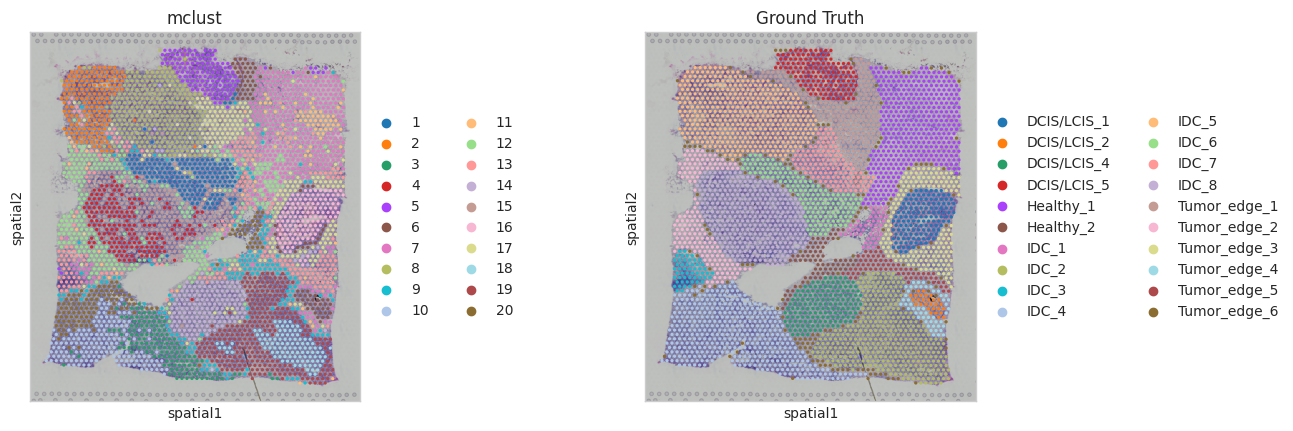

In [12]:
adata_hvg = CPS.mclust(adata_hvg, args, key='z_t', pca_dim=32)
sc.pl.spatial(adata_hvg, img_key="hires", color=["mclust",'Ground Truth'])

fitting ...
  |======================================================================| 100%


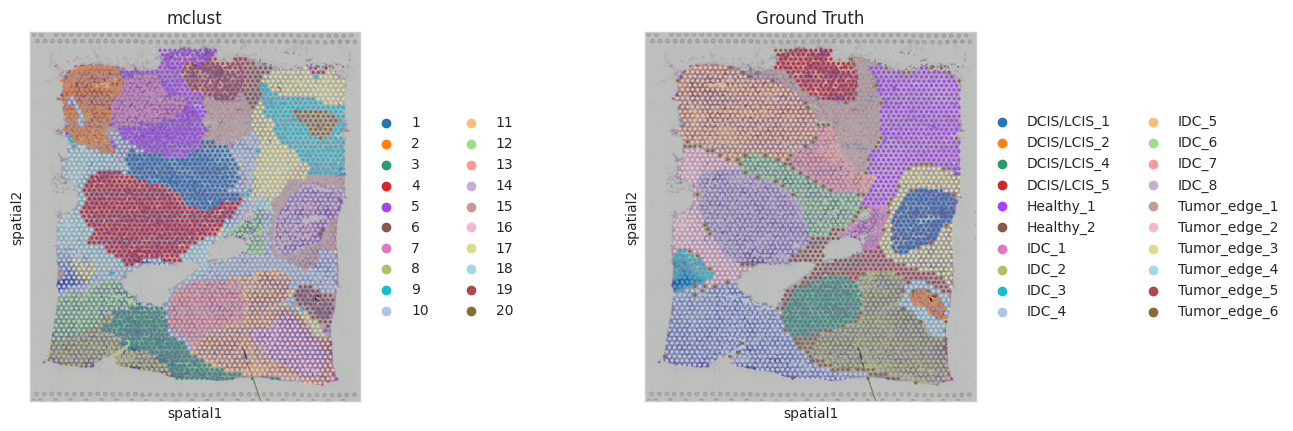

In [13]:
adata_hvg = CPS.mclust(adata_hvg, args, key='z_s', pca_dim=32)
sc.pl.spatial(adata_hvg, img_key="hires", color=["mclust",'Ground Truth'])

fitting ...
  |======================================================================| 100%


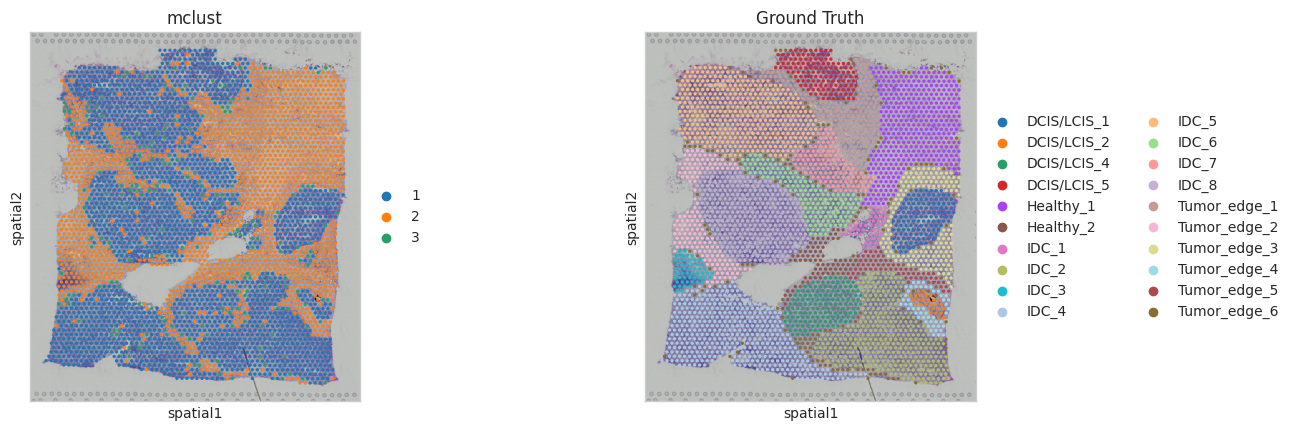

In [14]:
arg_3 = args
arg_3.clusters=3
adata_hvg = CPS.mclust(adata_hvg, arg_3, key='attn', pca_dim=16)
sc.pl.spatial(adata_hvg, img_key="hires", color=["mclust",'Ground Truth'])

In [15]:
adata_hvg.obsm['attn'][0]

array([0.68071896, 0.6935211 , 0.6971055 , 0.6836692 , 0.00223554,
       0.00213696, 0.00195894, 0.00235226, 0.2848249 , 0.27404752,
       0.27281296, 0.28100333, 0.01630007, 0.01540367, 0.01451443,
       0.01657753, 0.00731103, 0.00686386, 0.0063481 , 0.00749544,
       0.0040981 , 0.00382974, 0.00349148, 0.00422506, 0.00264709,
       0.00246525, 0.00222226, 0.0027406 , 0.00186431, 0.00173185,
       0.00154632, 0.00193664], dtype=float32)

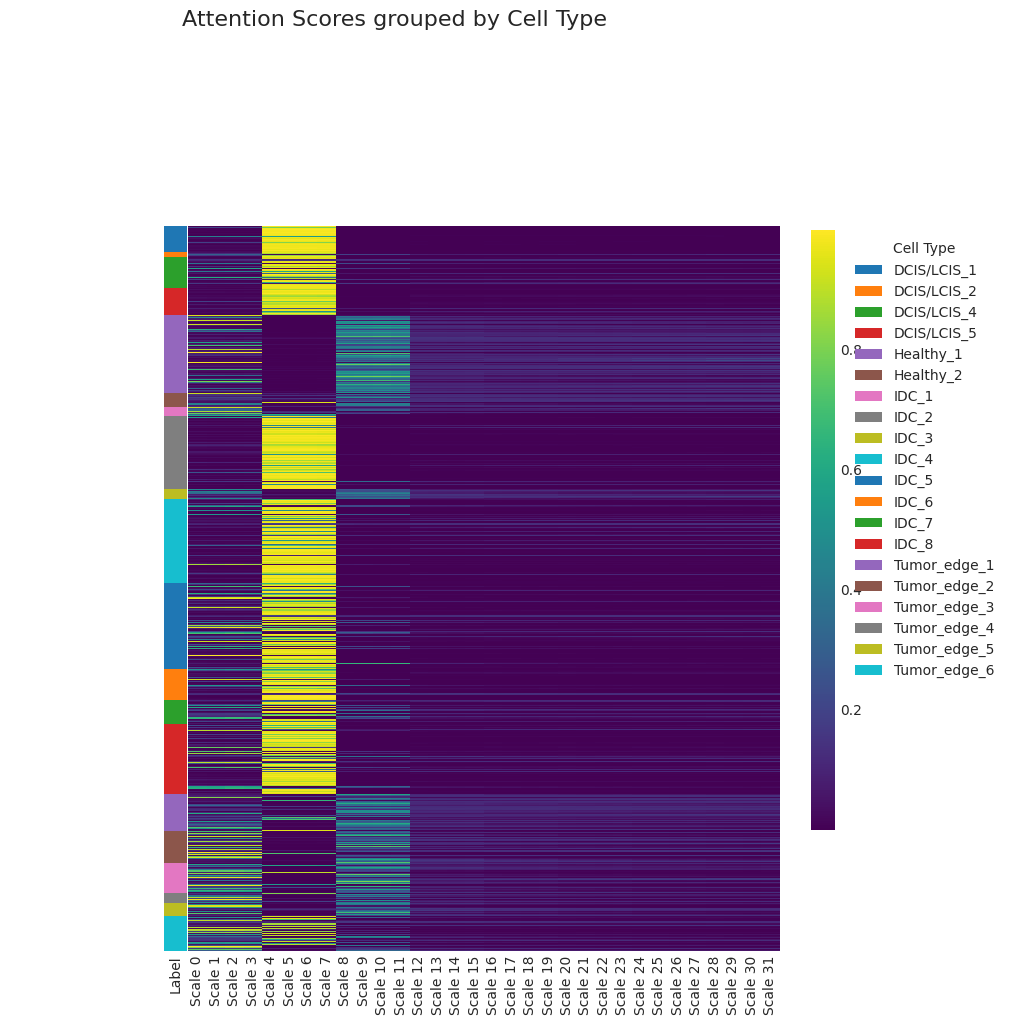

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. 准备数据 DataFrame
# 将 Attention 数据和 Label 数据合并
df_plot = pd.DataFrame(
    adata_hvg.obsm['attn'], 
    columns=[f'Scale {k}' for k in range(adata_hvg.obsm['attn'].shape[1])]
)
# 添加标签列
df_plot['Label'] = adata_hvg.obs['Ground Truth'].values

# 2. 关键步骤：按标签排序
# 这样同一种类的细胞就会在热图中聚在一起
df_sorted = df_plot.sort_values('Label')

# 3. 准备绘图数据
# 提取用于画热图的数值部分（去掉标签列）
data_heatmap = df_sorted.drop(columns=['Label'])
# 提取标签用于制作侧边颜色条
labels = df_sorted['Label']

# 4. 制作侧边类别颜色条 (Row Colors)
# 为每个类别分配一个颜色
lut = dict(zip(labels.unique(), sns.color_palette("tab10", len(labels.unique()))))
row_colors = labels.astype(object).map(lut)

# 5. 使用 Clustermap 绘图 (但关闭聚类)
# Clustermap 是最方便添加侧边颜色条的方法
g = sns.clustermap(
    data_heatmap,
    row_colors=row_colors,  # 左侧显示类别颜色
    row_cluster=False,      # 关闭行聚类（因为我们要保持按标签排序的顺序）
    col_cluster=False,      # 关闭列聚类（保持 Scale 从小到大的顺序）
    cmap='viridis',         # 颜色
    yticklabels=False,      # 隐藏具体的细胞名（太密了看不清）
    xticklabels=True,       # 显示 Scale 标签
    figsize=(8, 10),        # 调整大小
    cbar_pos=(1.02, 0.2, 0.03, 0.6) # 调整颜色条位置
)

# 添加标题
g.fig.suptitle('Attention Scores grouped by Cell Type', y=1.02, fontsize=16)

# (可选) 添加一个 Legend 来解释左侧的颜色条代表什么细胞类型
from matplotlib.patches import Patch
handles = [Patch(facecolor=lut[name]) for name in lut]
plt.legend(handles, lut, title='Cell Type', bbox_to_anchor=(1.3, 1), loc='upper left')

plt.show()

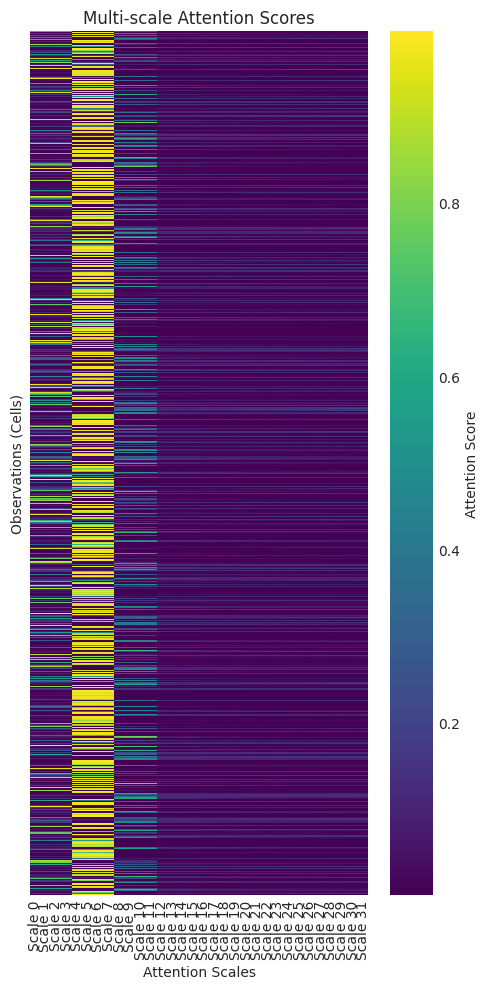

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. 准备数据
# 假设 adata_hvg.obsm['attn'] 是 numpy 数组
attn_data = adata_hvg.obsm['attn'] 

# (可选) 将其转换为 DataFrame 以获得更好的列标签
df_attn = pd.DataFrame(
    attn_data, 
    columns=[f'Scale {i}' for i in range(attn_data.shape[1])]
)

# 2. 绘图
plt.figure(figsize=(5, 10))  # 调整画布大小，适应长条形数据
sns.heatmap(
    df_attn,
    cmap='viridis',        # 推荐色谱: 'viridis', 'magma', 'Reds', 'Blues'
    xticklabels=True,      # 显示底部尺度标签
    yticklabels=False,     # 隐藏左侧细胞/样本标签（因数量太多）
    cbar_kws={'label': 'Attention Score'} # 颜色条标签
)

plt.title('Multi-scale Attention Scores')
plt.xlabel('Attention Scales')
plt.ylabel('Observations (Cells)')

plt.tight_layout()
plt.show() # 或者使用 plt.savefig('attn_heatmap.png') 保存

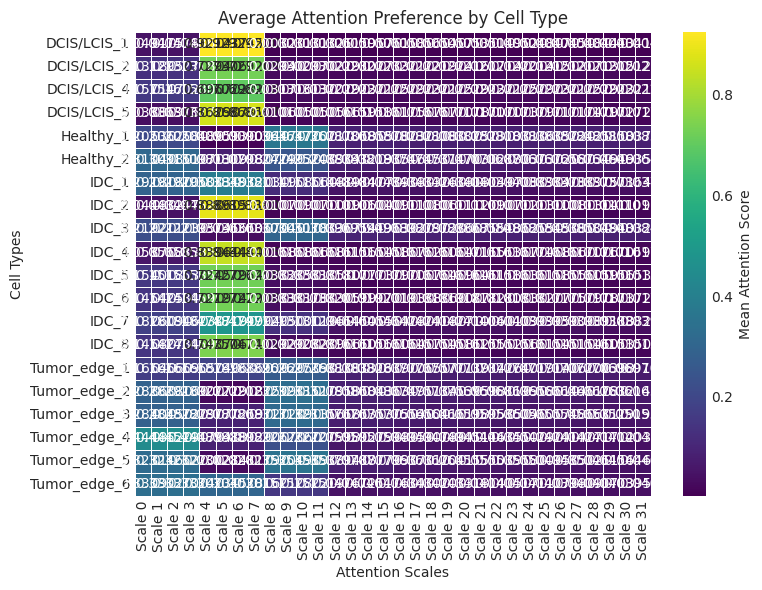

In [18]:
# 1. 准备数据
df_plot = pd.DataFrame(
    adata_hvg.obsm['attn'], 
    columns=[f'Scale {k}' for k in range(adata_hvg.obsm['attn'].shape[1])]
)
df_plot['Label'] = adata_hvg.obs['Ground Truth'].values

# 2. 关键步骤：按标签分组并求平均
df_mean = df_plot.groupby('Label').mean()

# 3. 绘图
plt.figure(figsize=(8, 6)) # 不需要太长，因为行数等于类别数
sns.heatmap(
    df_mean,
    cmap='viridis',
    annot=True,       # 在格子里显示具体数值，非常直观
    fmt=".4f",        # 数值保留两位小数
    linewidths=0.5,   # 格子之间加点间隔
    cbar_kws={'label': 'Mean Attention Score'}
)

plt.title('Average Attention Preference by Cell Type')
plt.xlabel('Attention Scales')
plt.ylabel('Cell Types')
plt.tight_layout()
plt.show()

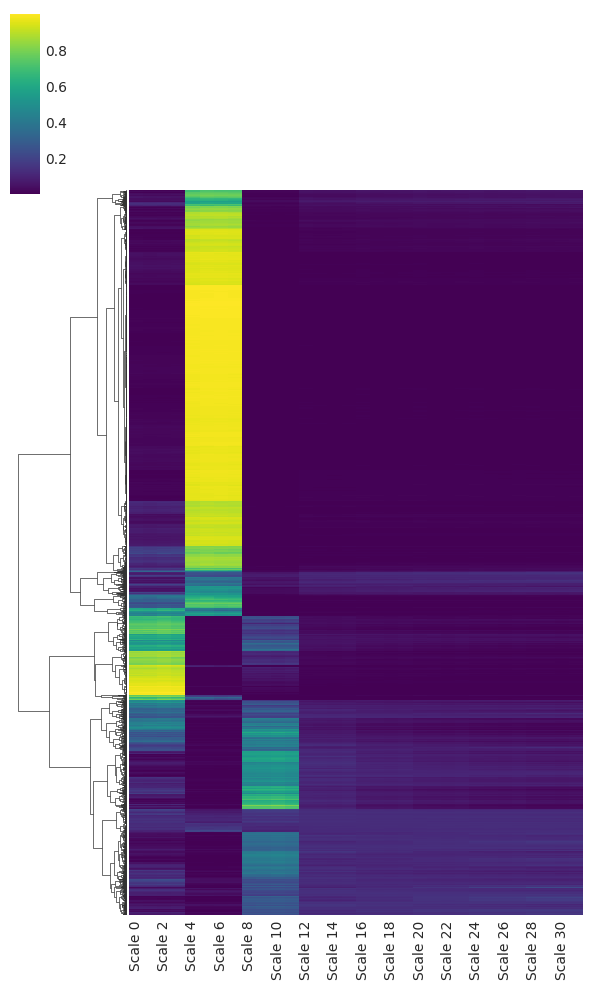

In [19]:
# 注意：对于3000多行，聚类可能会稍微花一点时间，且由于行数多，建议禁用行树状图显示或简化它
sns.clustermap(
    df_attn, 
    cmap='viridis', 
    col_cluster=False, # 如果不想改变尺度的顺序，设为 False
    yticklabels=False,
    figsize=(6, 10)
)

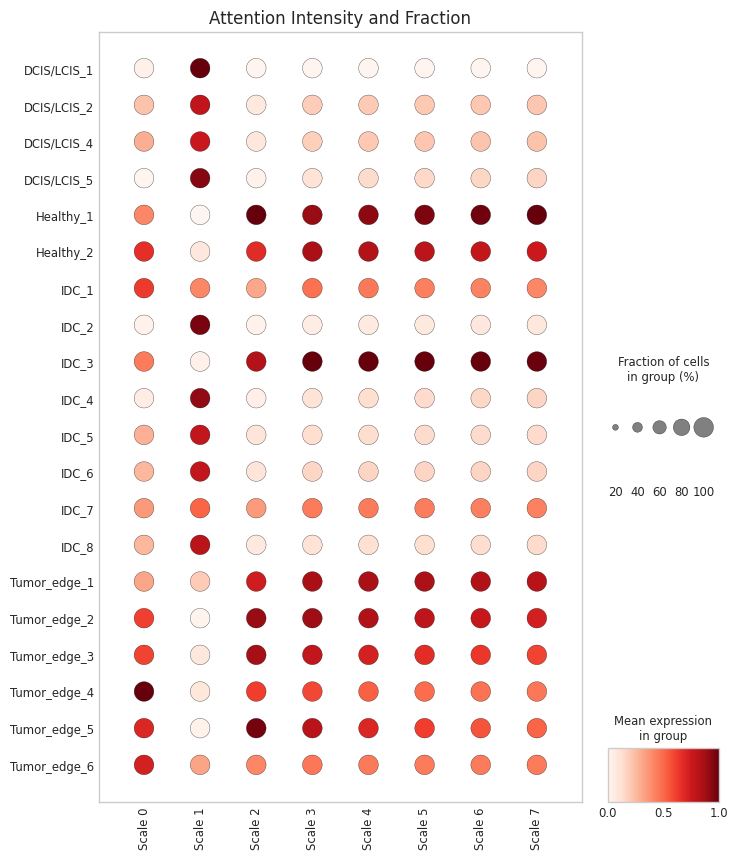

In [20]:
attn = np.mean(attn, axis=2)
adata_hvg.obsm['attn'] = attn
import scanpy as sc
import pandas as pd
import numpy as np

# 1. 提取数据
# 假设 adata_hvg.obsm['attn'] 的形状是 (n_cells, n_scales)
attn_data = adata_hvg.obsm['attn']
n_scales = attn_data.shape[1]

# 2. 构建临时的 AnnData 对象
# 我们将 attention score 当作 "基因" 放入 X 中
adata_attn = sc.AnnData(X=attn_data)

# 3. 转移元数据 (Obs)
# 必须把 Ground Truth 标签复制过来，用于分组
adata_attn.obs['Ground Truth'] = adata_hvg.obs['Ground Truth'].values

# 4. 命名变量 (Var)
# 给每一个尺度起个名字，这将成为横轴的标签
scale_names = [f'Scale {i}' for i in range(n_scales)]
adata_attn.var_names = scale_names

# 5. 绘制热点图 (Point plot)
# groupby: 纵轴的分组依据 (20个空间域)
# var_names: 横轴的变量 (不同尺度)
sc.pl.dotplot(
    adata_attn, 
    var_names=scale_names, 
    groupby='Ground Truth',
    standard_scale='var',  # 依然建议归一化，以便看清小尺度的变化
    cmap='Reds',
    figsize=(8, 10),
    title='Attention Intensity and Fraction'
)

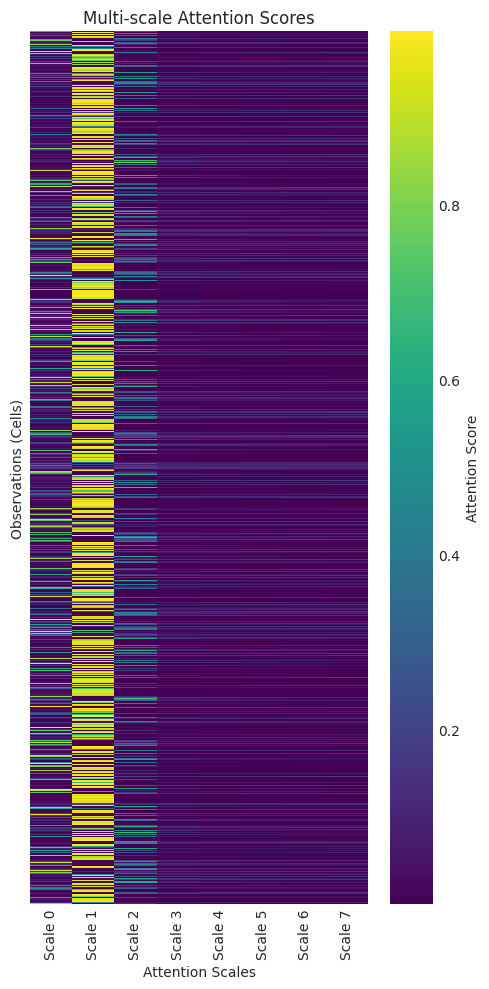

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. 准备数据
# 假设 adata_hvg.obsm['attn'] 是 numpy 数组
attn_data = adata_hvg.obsm['attn'] 

# (可选) 将其转换为 DataFrame 以获得更好的列标签
df_attn = pd.DataFrame(
    attn_data, 
    columns=[f'Scale {i}' for i in range(attn_data.shape[1])]
)

# 2. 绘图
plt.figure(figsize=(5, 10))  # 调整画布大小，适应长条形数据
sns.heatmap(
    df_attn,
    cmap='viridis',        # 推荐色谱: 'viridis', 'magma', 'Reds', 'Blues'
    xticklabels=True,      # 显示底部尺度标签
    yticklabels=False,     # 隐藏左侧细胞/样本标签（因数量太多）
    cbar_kws={'label': 'Attention Score'} # 颜色条标签
)

plt.title('Multi-scale Attention Scores')
plt.xlabel('Attention Scales')
plt.ylabel('Observations (Cells)')

plt.tight_layout()
plt.show() # 或者使用 plt.savefig('attn_heatmap.png') 保存

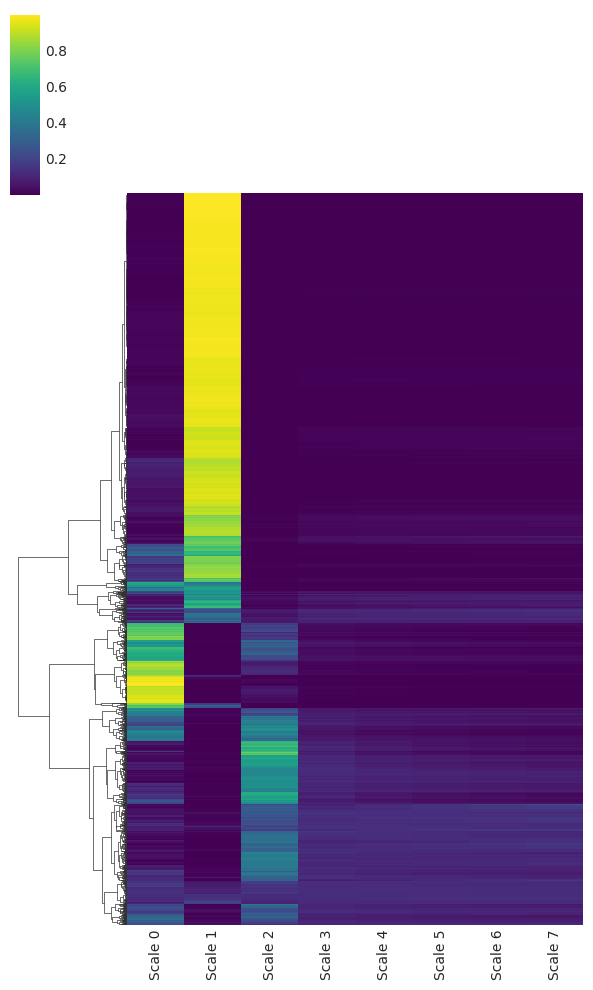

In [22]:
sns.clustermap(
    df_attn, 
    cmap='viridis', 
    col_cluster=False, # 如果不想改变尺度的顺序，设为 False
    yticklabels=False,
    figsize=(6, 10)
)

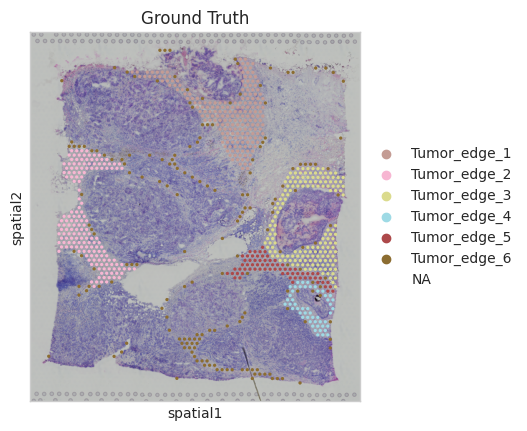

In [23]:
sc.pl.spatial(adata, img_key="hires", color=["Ground Truth"], groups=['Tumor_edge_1','Tumor_edge_2',
                                                                      'Tumor_edge_3','Tumor_edge_4',
                                                                      'Tumor_edge_5','Tumor_edge_6'])

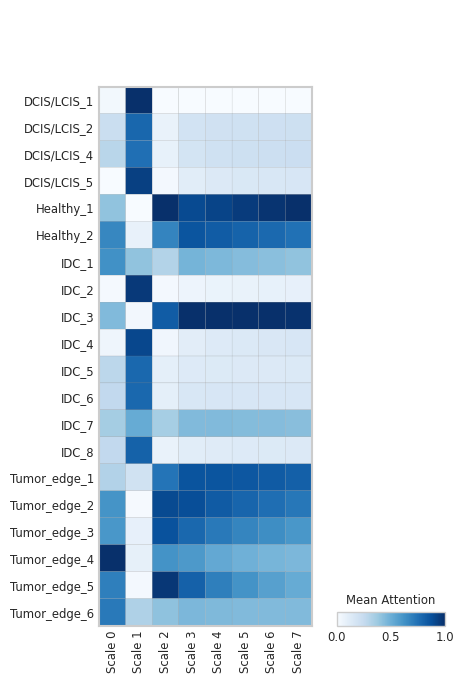

In [24]:
sc.pl.matrixplot(
    adata_attn, 
    var_names=scale_names, 
    groupby='Ground Truth', 
    colorbar_title='Mean Attention',
    cmap='Blues',
    standard_scale='var' # 可选：对每个尺度进行归一化 (0-1)，便于对比
)

In [25]:
# attn = np.clip(attn, 1e-10, 1.0)
attn = attn / attn.sum(axis=1, keepdims=True)
weights = np.arange(1, 9)  # 尺度权重
SES = attn @ weights
# SE = -np.sum(attn * np.log(attn), axis=1)
SE = -np.sum(attn * np.log(attn), axis=1)
adata_hvg.obs['SES'] = SES
adata_hvg.obs['SE'] = SE

[<Axes: title={'center': 'SES'}, xlabel='spatial1', ylabel='spatial2'>]

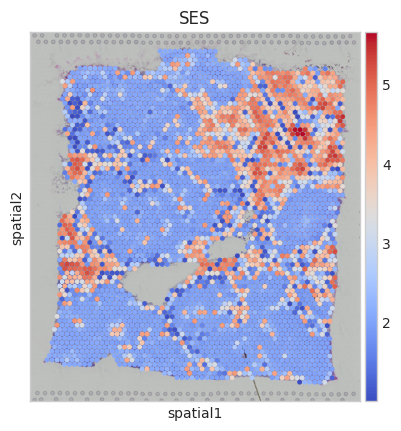

In [26]:
temp_adata = adata_hvg.copy()
temp_adata.obs['SES'] = SES
sc.pl.spatial(temp_adata, 
                color='SES',
                show=False, cmap='coolwarm',
                size=1.5)

[<Axes: title={'center': 'SE'}, xlabel='spatial1', ylabel='spatial2'>]

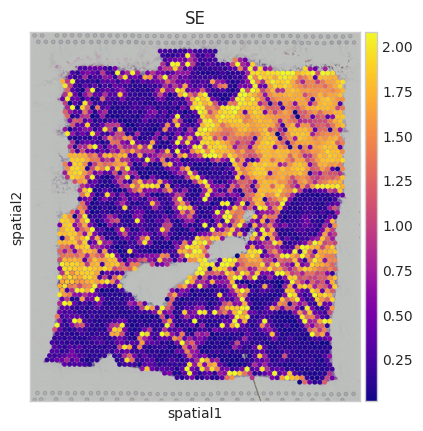

In [27]:
temp_adata = adata_hvg.copy()
temp_adata.obs['SE'] = SE
sc.pl.spatial(temp_adata, 
                color='SE',
                show=False, 
                cmap='plasma',
                size=1.5)

IDC1-4 vs IDC5-8

In [28]:

import scanpy as sc
import pandas as pd
import numpy as np

# 1. 创建一个新的子集，只包含 IDC 细胞
# 假设你的标签在 'Ground Truth' 列
idc_sub = adata_hvg[adata_hvg.obs['Ground Truth'].str.contains('IDC')].copy()

# 2. 定义分组逻辑
def define_idc_group(label):
    # 提取数字部分，例如 "IDC_1" -> 1
    try:
        num = int(label.split('_')[1])
        if 1 <= num <= 4:
            return 'IDC_1-4 (Small Scale)' # 假设这是之前看小尺度的一组
        elif 5 <= num <= 8:
            return 'IDC_5-8 (Large Scale)' # 假设这是之前看大尺度的一组
        else:
            return 'Other'
    except:
        return 'Other'

# 3. 应用分组
idc_sub.obs['IDC_Group'] = idc_sub.obs['Ground Truth'].apply(define_idc_group)

# 检查一下分组数量
print(idc_sub.obs['IDC_Group'].value_counts())

IDC_5-8 (Large Scale)    1103
IDC_1-4 (Small Scale)     924
Name: IDC_Group, dtype: int64


Up-regulated in IDC 5-8: 86 genes
Up-regulated in IDC 1-4: 330 genes


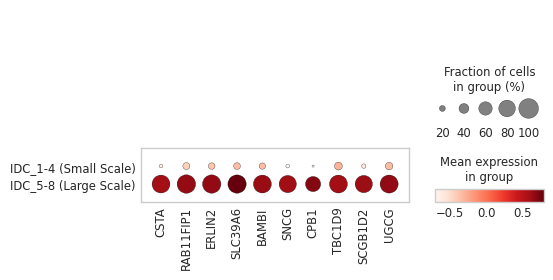

In [29]:
# 1. 确保使用归一化后的数据 (通常是 log1p 后的)
# sc.pp.normalize_total(idc_sub, target_sum=1e4)
# sc.pp.log1p(idc_sub)

# 2. 计算差异基因
# reference='IDC_1-4 (Small Scale)' 意味着：
# 正值 (positive scores) = 在 IDC 5-8 中高表达
# 负值 (negative scores) = 在 IDC 1-4 中高表达
sc.tl.rank_genes_groups(idc_sub, groupby='IDC_Group', method='wilcoxon', 
                        reference='IDC_1-4 (Small Scale)', groups=['IDC_5-8 (Large Scale)'])

# 3. 提取结果为 DataFrame
result = sc.get.rank_genes_groups_df(idc_sub, group='IDC_5-8 (Large Scale)')

# 过滤出显著的基因 (例如 pvals_adj < 0.05 & logfoldchanges > 1)
# 这一步是为了给后面的通路分析做准备
up_genes = result[(result.pvals_adj < 0.05) & (result.logfoldchanges > 0.5)]['names'].tolist()
down_genes = result[(result.pvals_adj < 0.05) & (result.logfoldchanges < -0.5)]['names'].tolist()

print(f"Up-regulated in IDC 5-8: {len(up_genes)} genes")
print(f"Up-regulated in IDC 1-4: {len(down_genes)} genes")

# 4. 可视化：火山图或 DotPlot
# 选出最显著的前 10 个基因画图看看
top_genes = result.head(10)['names'].tolist()
sc.pl.dotplot(idc_sub, top_genes, groupby='IDC_Group', dendrogram=True)

In [30]:
# import gseapy as gp
# import matplotlib.pyplot as plt

# # 选择基因集库：
# # 'KEGG_2021_Human', 'MSigDB_Hallmark_2020', 'GO_Biological_Process_2023'
# gene_sets = ['MSigDB_Hallmark_2020', 'GO_Biological_Process_2023']

# # 1. 分析 IDC 5-8 高表达的通路 (Up-regulated)
# enr_up = gp.enrichr(gene_list=up_genes,
#                  gene_sets=gene_sets,
#                  organism='human', # or 'mouse'
#                  outdir=None)

# # 2. 分析 IDC 1-4 高表达的通路 (Down-regulated / Base)
# enr_down = gp.enrichr(gene_list=down_genes,
#                  gene_sets=gene_sets,
#                  organism='human',
#                  outdir=None)

# # 3. 绘图 (Dotplot)
# # 展示 IDC 5-8 的前15个显著通路
# from gseapy import dotplot
# ax = dotplot(enr_up.res2d, title='Pathways Enriched in IDC 5-8', cmap='viridis_r', size=10, top_term=15)
# plt.show()

# # 展示 IDC 1-4 的前15个显著通路
# ax = dotplot(enr_down.res2d, title='Pathways Enriched in IDC 1-4', cmap='viridis_r', size=10, top_term=15)
# plt.show()

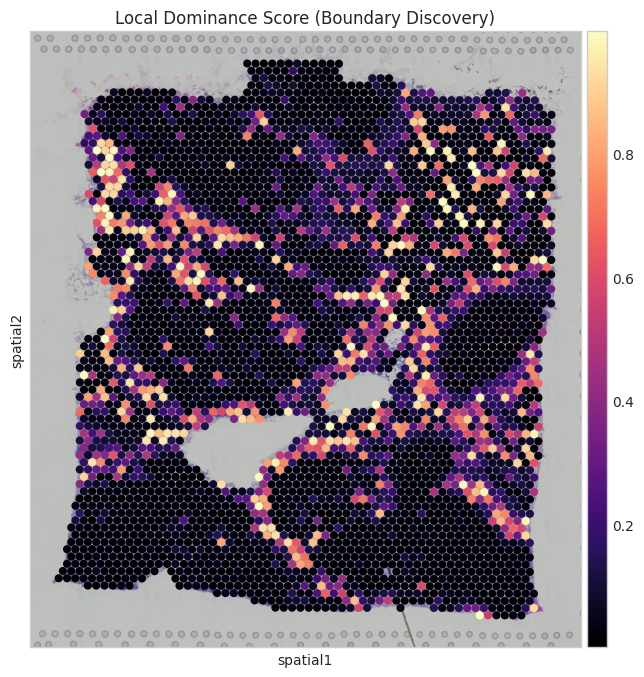

In [31]:
# ==========================================
# 新增功能：计算并可视化局部主导度 (Local Dominance)
# ==========================================

# 1. 定义什么是“局部”尺度
# 这里我们要累加前 k_local_threshold + 1 个尺度的权重
# 如果 k_local_threshold = 1，则累加 k=0 (Self) 和 k=1 (1-hop)
k_local_threshold = 1

# 2. 计算局部主导度得分
# attn 已经是归一化过的 (sum=1)，所以直接累加局部列即可
# attn[:, :2] 取的是第0列和第1列
local_attn_score = np.sum(attn[:, :k_local_threshold], axis=1)

# 3. 将得分保存到 adata.obs 中以便绘图
adata.obs['Local_Dominance'] = local_attn_score

# 4. 可视化
# 使用 'magma' 色谱 (黑色-紫色-亮黄)，亮黄色代表高局部主导度(即潜在的边界)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.spatial(adata, 
              img_key="hires", 
              color='Local_Dominance', 
              cmap='magma', 
              size=1.5, 
              title='Local Dominance Score (Boundary Discovery)',
              ax=ax,
              show=False)

# 可选：保存图片
# plt.savefig('Local_Dominance_Boundary.png', dpi=300, bbox_inches='tight')
plt.show()

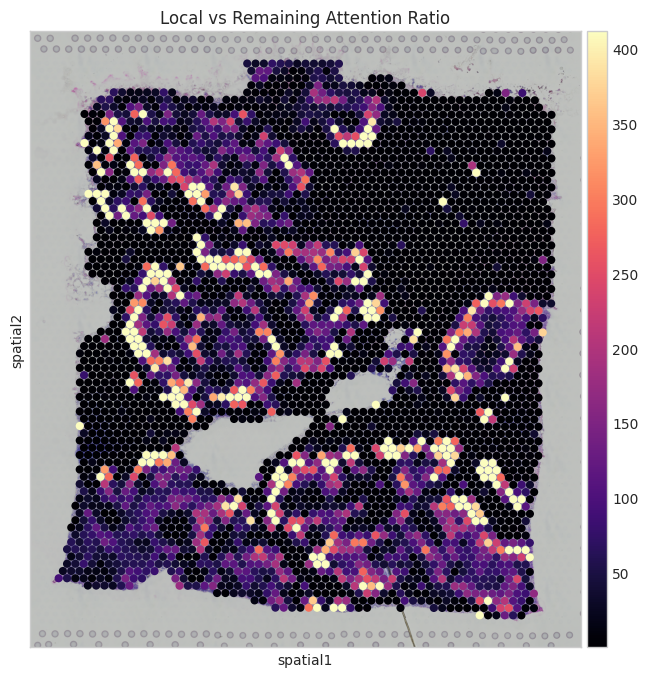

In [32]:
# ==========================================
# 进阶版：计算“局部 vs 剩余”注意力比率 (Local-to-Remaining Ratio)
# ==========================================
import numpy as np

# 1. 定义局部阈值 (k=0 和 k=1 为局部)
k_local_threshold = 2

# 2. 分别计算“局部”和“剩余”的权重和
# 局部 (Local): k <= 1
local_sum = np.sum(attn[:, :k_local_threshold], axis=1)

# 剩余 (Remaining/Global): k > 1
remaining_sum = np.sum(attn[:, k_local_threshold:], axis=1)

# 3. 计算比率 (Ratio)
# 加上一个极小值 1e-6 防止除以零 (如果 remaining_sum 为 0)
# 这个指标的物理含义：局部注意力是长程注意力的多少倍？
# 在边界处，这个值可能会非常大（例如 局部0.9 / 剩余0.1 = 9倍）
ratio_score = local_sum / (remaining_sum + 1e-6)

# (可选) 如果比率极值太大，可以取个 log 压缩一下范围，方便画图
# ratio_score = np.log1p(ratio_score) 

# 4. 保存并画图
adata.obs['Local_Global_Ratio'] = ratio_score

fig, ax = plt.subplots(figsize=(8, 8))
sc.pl.spatial(adata, 
              img_key="hires", 
              color='Local_Global_Ratio', 
              cmap='magma',  # 依然推荐 magma 或 inferno，高值亮黄
              size=1.5,
              # 设定 vmax 可以防止个别极端值掩盖整体趋势，
              # np.percentile(ratio_score, 95) 表示只看前 95% 的数值分布
              vmax=np.percentile(ratio_score, 95), 
              title='Local vs Remaining Attention Ratio',
              ax=ax,
              show=False)

plt.show()